⚔️ Starting Historical Comparison (2018 vs 2023)...

📅 Analyze Year: 2018
   Found 31 scenes.

📅 Analyze Year: 2023
   Found 36 scenes.

📊 Generating Comparison Graph...


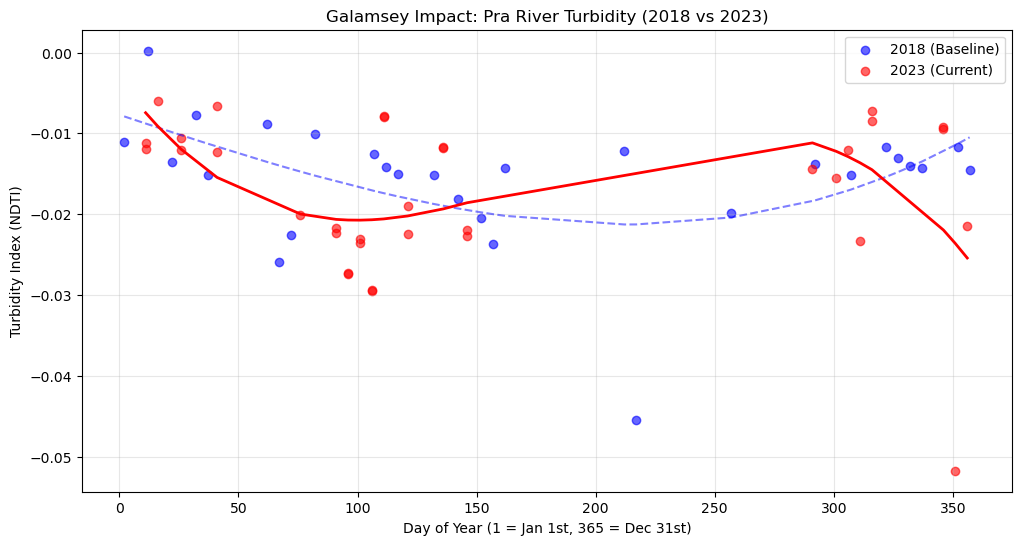

In [1]:
import pystac_client
import planetary_computer
import rasterio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


AOI_BBOX = [-1.58, 5.55, -1.52, 5.65] 

YEARS = [2018, 2023] 

print(" Starting Historical Comparison (2018 vs 2023)...")

catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace
)

all_results = []

for year in YEARS:
    print(f"\n📅 Analyze Year: {year}")
    
    search = catalog.search(
        collections=["sentinel-2-l2a"],
        bbox=AOI_BBOX,
        datetime=f"{year}-01-01/{year}-12-31",
        query={"eo:cloud_cover": {"lt": 50}}, 
    )
    items = search.item_collection()
    print(f"   Found {len(items)} scenes.")
    
    for item in items:
        try:
        
            href_red = item.assets["B04"].href
            href_green = item.assets["B03"].href
            href_nir = item.assets["B08"].href

            with rasterio.open(href_red) as src:
                red = src.read(1, out_shape=(src.height // 10, src.width // 10))
            with rasterio.open(href_green) as src:
                green = src.read(1, out_shape=(src.height // 10, src.width // 10))
            with rasterio.open(href_nir) as src:
                nir = src.read(1, out_shape=(src.height // 10, src.width // 10))

         
            np.seterr(divide='ignore', invalid='ignore')
            r, g, n = red.astype(float), green.astype(float), nir.astype(float)
            
            ndti = (r - g) / (r + g)
            ndwi = (g - n) / (g + n)

            
            river_pixels = ndti[ndwi > 0.0]

          
            if len(river_pixels) > 300:
                avg = np.nanmean(river_pixels)
                # Filter out crazy outliers (sometimes clouds look like water)
                if -0.3 < avg < 0.5: 
                    all_results.append({"Year": str(year), "Date": item.datetime, "Turbidity": avg})

        except:
            pass 


print("\n📊 Generating Comparison Graph...")
df = pd.DataFrame(all_results)

if not df.empty:
    plt.figure(figsize=(12, 6))
    
    # Plot 2018
    df_18 = df[df["Year"] == "2018"].sort_values("Date")
    # We use a trick to overlay them: Extract Month-Day for X-axis
    df_18["DayOfYear"] = df_18["Date"].apply(lambda x: x.timetuple().tm_yday)
    plt.scatter(df_18["DayOfYear"], df_18["Turbidity"], color='blue', alpha=0.6, label='2018 (Baseline)')
    
    
    if len(df_18) > 3:
        z = np.polyfit(df_18["DayOfYear"], df_18["Turbidity"], 3)
        p = np.poly1d(z)
        plt.plot(df_18["DayOfYear"], p(df_18["DayOfYear"]), "b--", alpha=0.5)

    # Plot 2023
    df_23 = df[df["Year"] == "2023"].sort_values("Date")
    df_23["DayOfYear"] = df_23["Date"].apply(lambda x: x.timetuple().tm_yday)
    plt.scatter(df_23["DayOfYear"], df_23["Turbidity"], color='red', alpha=0.6, label='2023 (Current)')
    
  
    if len(df_23) > 3:
        z = np.polyfit(df_23["DayOfYear"], df_23["Turbidity"], 3)
        p = np.poly1d(z)
        plt.plot(df_23["DayOfYear"], p(df_23["DayOfYear"]), "r-", linewidth=2)

    plt.title("Galamsey Impact: Pra River Turbidity (2018 vs 2023)")
    plt.xlabel("Day of Year (1 = Jan 1st, 365 = Dec 31st)")
    plt.ylabel("Turbidity Index (NDTI)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.savefig("Pra_River_Comparison.png")
    plt.show()
else:
    print("Not enough data found.")